## Quantifying the World
### Case Study 8 - Stock Price Time Series Prediction Using ARIMAS
#### Kelly Carter, Swee K Chew, Vlad Orlov, Anjli Solsi

### Introduction 

The stock market has continually been the great equalizer of the investing world. Posing the greatest chance for gains and the greatest chance for loss of all investment vehicles, investors need to be willing to risk their funds when taking a chance on equity investing. In this analysis we will focus on a more stable stock, Coca-Cola. Its long investment history, strong public sentiment, and customer loyalty make it an ideal candidate for analysis as strong consumer staples are often more resistant the extreme ups and downs of the stock market.

### Background

Coca-Cola (KO) was first established on the New York Stock Exchange (NYSE) in 1919 and began paying dividends in 1920 [1]. Coca-Cola has shown staggering consistency, increasing their dividends for 57 consecutive years as of the end of 2019 [2]. This consistency has helped establish them as a leading company in the consumer staples sector of the NYSE. Additionally, their large market cap of above $230B establishes them as a Megacap stock, a designation reserved for the largest publically traded companies in the investment universe [3]. These factors contributed to Coca-Cola’s inclusion in the Dow Jones Industrial Index (DJIA) in 1987, where it still remains today. The Dow Jones’ purpose is to cover all major sectors of the US Stock Market and present an accurate snapshot of the health of the overall market [4]. As Coca-Cola sells more than 1.9 billion drinks a day, it’s easy to see why this stock is an ideal representative for the overall beverage market [5].

### Methods

In this analysis we will specifically focus on the last five years of Coca-Cola daily stock prices and use this to create a time series model to forecast future stock prices. Using the ARIMA package in Python, we will create a time series model with ARIMAS. ARIMAS stands for Autoregressive, Integrated, Moving Average, Seasonality; in this case study we will not be looking at the seasonality component [6].
An ARIMA model is represented by a combination of three parameters: p, which represents the autoregressive portion, d, which represents the integrated part, and q, which represent the moving average. The goal is to find the ideal combination of p, d, and q parameters that best represents the five years of stock data. We will do this by two methods: intuition through the use of plots and a grid search which examines all of combinations of 0 to 3 for the p, d, and q parameters. There are several rules that must be kept in mind when determining the parameters, the most important of which is that both p and q cannot be greater than one [6]. Once we have a chosen a model, it will be used to forecast future values.

In [1]:
%matplotlib inline

In [2]:
# import necessary libraries
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt
import matplotlib 
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.tsa.arima_model import ARIMA

In [3]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,7)

#### Select Stock and Plot Data

For our analysis, we decided to use the *Coca-Cola Co.* (KO) stock price. We first extract 5 years of historical data from Yahoo Finance.

In [4]:
STOCK_SYMBOL = 'KO'

In [5]:
# obtain 5 years of historical data of Coca-Cola (KO) stock price
import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as web
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2020, 2, 20)
price = web.DataReader(STOCK_SYMBOL, 'yahoo', start, end)['Close']
price.index = pd.to_datetime(price.index)

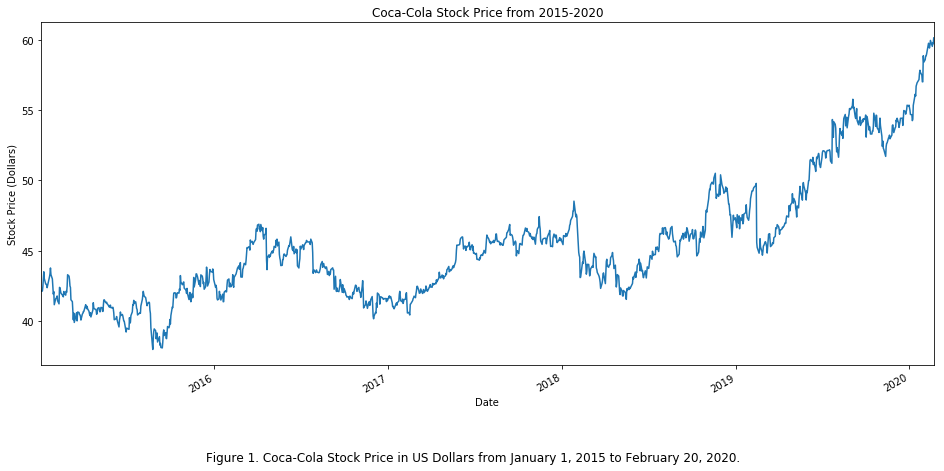

In [6]:
# Plot of historical data
import matplotlib.pyplot as plt
plt.title("Coca-Cola Stock Price from 2015-2020")
plt.ylabel('Stock Price (Dollars)')
txt="Figure 1. Coca-Cola Stock Price in US Dollars from January 1, 2015 to February 20, 2020."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
price.plot()

The *KO* stock price data over time is shown in Figure 1. The stock price fluctuates over time as one would expect, however, we can see that the stock price continues to increase starting late 2019 to up until now. 

### Analysis

We will create a function to calculate the rolling mean and rolling standard deviation of the time series and plot them in one graph along with the data to see how the mean and standard deviation change over time. We will also create a function to implement the Dickey-Fuller test. 

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.ylabel('Stock Price (Dollars)') 
    plt.xlabel('Date')  
    plt.xticks(rotation=45)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#### Addressing Stationarity

In order for a time series to be stationary, it needs to have a constant mean and a constant variance across time. Plotting the rolling mean and rolling standard deviation (the square root of variance) over time will be able to tell if the time series is stationary or non-stationary. 

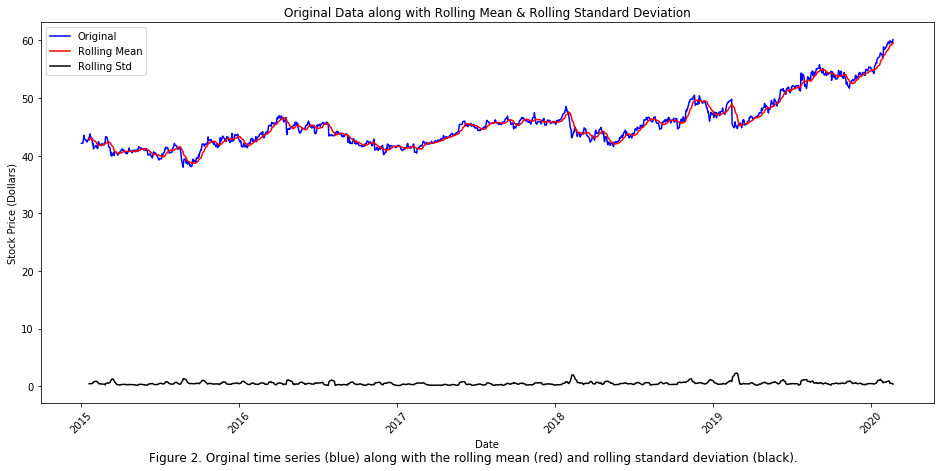

Results of Dickey-Fuller Test:
Test Statistic                    0.244366
p-value                           0.974643
#Lags Used                        2.000000
Number of Observations Used    1290.000000
Critical Value (1%)              -3.435429
Critical Value (5%)              -2.863783
Critical Value (10%)             -2.567964
dtype: float64


In [8]:
# Plot to check if stock price is stationary 
plt.title('Original Data along with Rolling Mean & Rolling Standard Deviation')
txt="Figure 2. Orginal time series (blue) along with the rolling mean (red) and rolling standard deviation (black)."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
test_stationarity(price)

Based on Figure 2, the rolling mean seems to align with the original time series pretty well with up and down trends. The standard deviation seems to have some noises but it appears to be constant over time. 

The Dickey-Fuller test has a p-value of 0.97, which indicates that the time series is non-stationary. We want the p-value to be below 0.05 to be able to reject the null hypothesis. Since we want to make the time series be stationary, we will next substract the trend from the series to make it more stationary. 

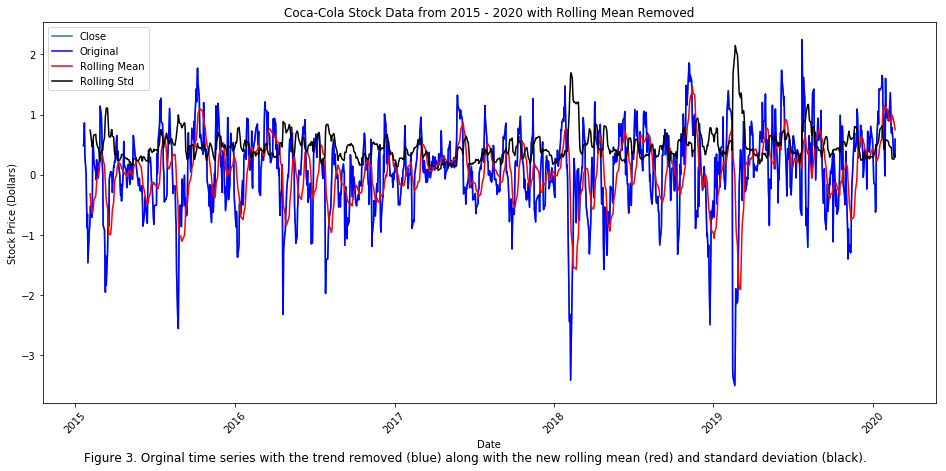

Results of Dickey-Fuller Test:
Test Statistic                -1.102200e+01
p-value                        5.955290e-20
#Lags Used                     7.000000e+00
Number of Observations Used    1.274000e+03
Critical Value (1%)           -3.435493e+00
Critical Value (5%)           -2.863811e+00
Critical Value (10%)          -2.567979e+00
dtype: float64


In [9]:
# Subtract the rolling mean and check for stationary
moving_avg = price.rolling(12).mean()
no_trend = price - moving_avg
plt.plot(no_trend)
plt.title("Coca-Cola Stock Data from 2015 - 2020 with Rolling Mean Removed")
txt="Figure 3. Orginal time series with the trend removed (blue) along with the new rolling mean (red) and standard deviation (black)."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
test_stationarity(no_trend.dropna())

Figure 3 shows that removing the rolling mean makes the time series more noisy. The rolling mean and rolling standard deviation also looks noisy. The Dickey-Fuller test does show a p-value that is less than 0.05, which indicates that there is not enough evidence that the time series is not stationary.

However, we will try some differencing to see whether it can make the series more stationary than removing the rolling mean. This determines if we use a difference term or not. We will use 1 shift ($y_t - y_{t-1}$) here, which means we are adding d=1 term.

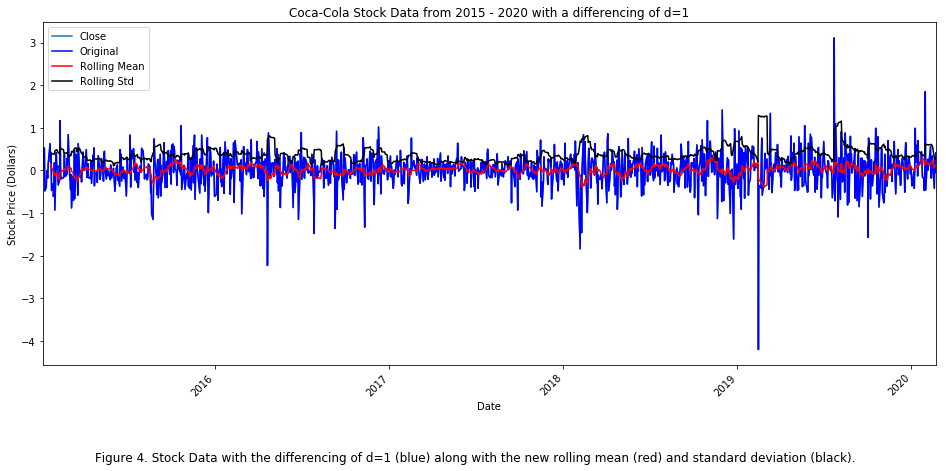

Results of Dickey-Fuller Test:
Test Statistic                  -27.968147
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1290.000000
Critical Value (1%)              -3.435429
Critical Value (5%)              -2.863783
Critical Value (10%)             -2.567964
dtype: float64


In [10]:
# Remove the trend by subtracting the difference 
diff = price - price.shift()
diff.dropna(inplace=True)
diff.plot()

plt.title("Coca-Cola Stock Data from 2015 - 2020 with a differencing of d=1")
txt="Figure 4. Stock Data with the differencing of d=1 (blue) along with the new rolling mean (red) and standard deviation (black)."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
test_stationarity(diff)

Differencing seems to adjust the scale for the y-axis as shown in Figure 4. The resulting time series also resembles a white noise.

The test statistic for this one is -27.968, which is lower than the previous one (-11.022) with the rolling mean removed. The more negative the test statistic, the higher the p-value and thus the more we want to reject the null hypothesis. Since the differencing makes the original data stationary, we will add the term d=1 in our final model.

#### Plot ACF and PACF 

Next, we will look at the autocorrelation (ACF) and the partial autocorrelation (PACF) plots of the differenced data to determine which p and q terms will be appropriate to use. The ACF plot will help us determine the q term and the PACF will help with the p term.

Text(0.3,0.01,'Figure 5. Autocorrelation Plot (ACF) of the Differenced Data with nlags=20.')

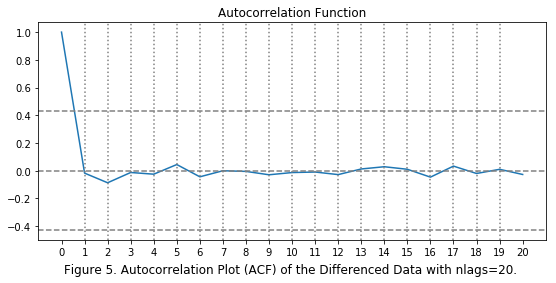

In [11]:
from statsmodels.tsa.stattools import acf, pacf
acf_air_plot = acf(diff, nlags=20)

#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Autocorrelation Function')
txt="Figure 5. Autocorrelation Plot (ACF) of the Differenced Data with nlags=20."
plt.figtext(0.3, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

Text(0.3,0.01,'Figure 6. Partial Autocorrelation Plot (PACF) of the Differenced Data with nlags=20.')

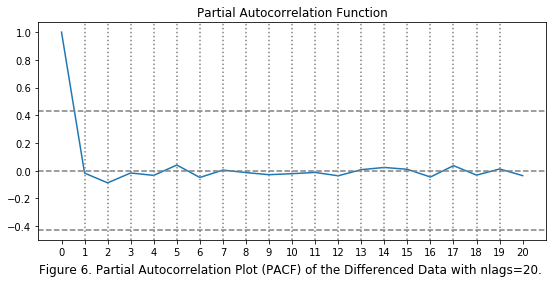

In [12]:
pacf_air_plot = pacf(diff, nlags=20)
#Plot PACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(pacf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Partial Autocorrelation Function')
txt="Figure 6. Partial Autocorrelation Plot (PACF) of the Differenced Data with nlags=20."
plt.figtext(0.3, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

The ACF and PACF plots in Figure 5 and Figure 6 both indicate that p and q could be 0 or 1. In the next section, we will fit some models to see which one of them gives a better result.

#### Manually Fit Models 

We will manually fit the ARIMA (1,1,0) and ARIMA (0,1,1) models and look at the residuals plots to see whether they are well distributed. 

/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1292
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -693.719
Method:                       css-mle   S.D. of innovations              0.414
Date:                Sun, 01 Mar 2020   AIC                           1393.439
Time:                        21:42:28   BIC                           1408.930
Sample:                             1   HQIC                          1399.253
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0139      0.011      1.231      0.219      -0.008       0.036
ar.L1.D.Close    -0.0183      0.028     -0.657      0.512      -0.073       0.036
                                    Root

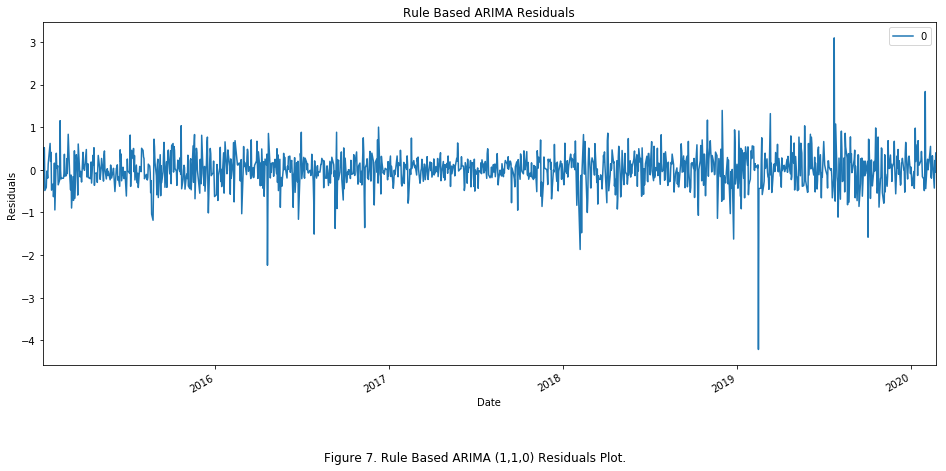

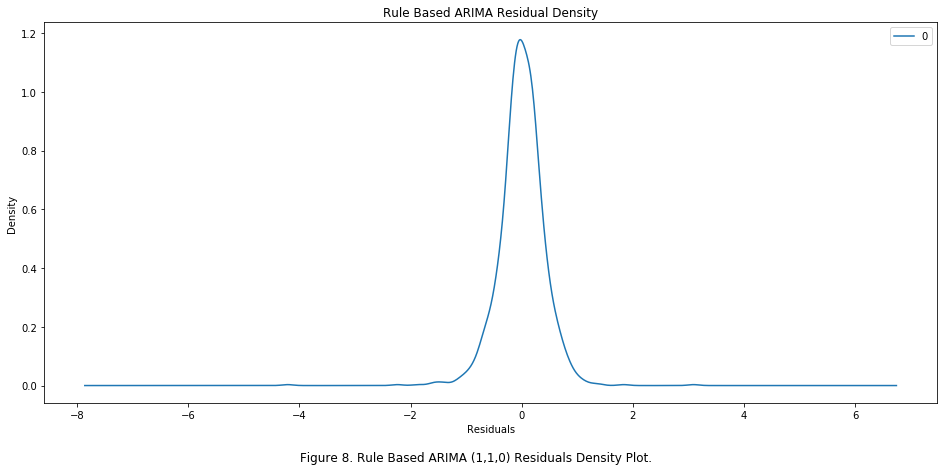

                  0
count  1.292000e+03
mean  -1.915643e-07
std    4.141127e-01
min   -4.211799e+00
25%   -2.004501e-01
50%    2.470164e-03
75%    2.189781e-01
max    3.092723e+00


In [13]:
# selected ARIMA(1,1,0) model
model = ARIMA(price, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.title('Rule Based ARIMA Residuals')
plt.ylabel('Residuals')
txt="Figure 7. Rule Based ARIMA (1,1,0) Residuals Plot."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

residuals.plot(kind='kde')
plt.title('Rule Based ARIMA Residual Density')
plt.xlabel('Residuals')
txt="Figure 8. Rule Based ARIMA (1,1,0) Residuals Density Plot."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

print(residuals.describe())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1292
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -693.673
Method:                       css-mle   S.D. of innovations              0.414
Date:                Sun, 01 Mar 2020   AIC                           1393.346
Time:                        21:42:28   BIC                           1408.838
Sample:                             1   HQIC                          1399.160
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0139      0.011      1.236      0.217      -0.008       0.036
ma.L1.D.Close    -0.0222      0.031     -0.724      0.469      -0.082       0.038
                                    Root

/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


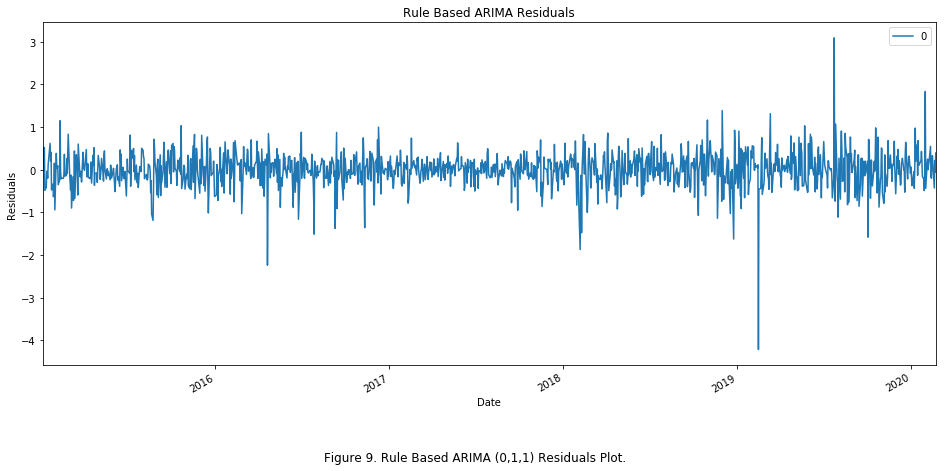

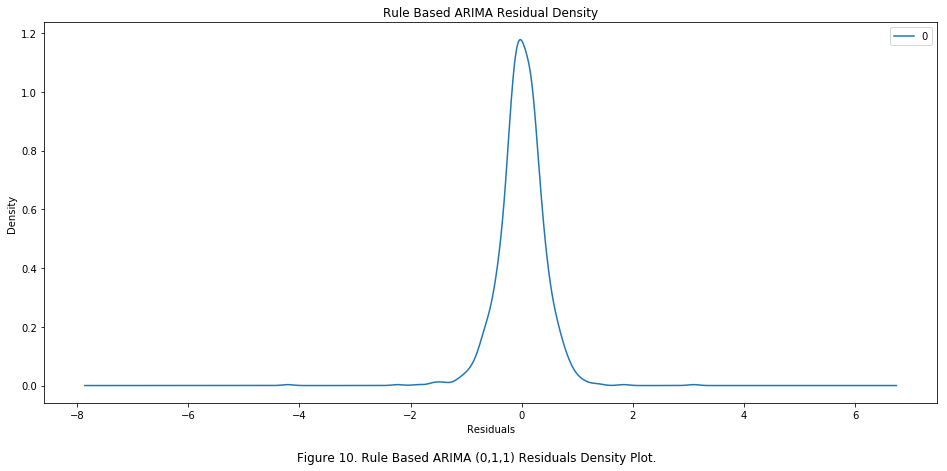

                  0
count  1.292000e+03
mean  -1.167848e-07
std    4.140978e-01
min   -4.211322e+00
25%   -2.000443e-01
50%    2.537472e-03
75%    2.207194e-01
max    3.091676e+00


In [14]:
# selected ARIMA(0,1,1) model
model = ARIMA(price, order=(0,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.title('Rule Based ARIMA Residuals')
plt.ylabel('Residuals') 
txt="Figure 9. Rule Based ARIMA (0,1,1) Residuals Plot."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

residuals.plot(kind='kde')
plt.title('Rule Based ARIMA Residual Density')
plt.xlabel('Residuals')
txt="Figure 10. Rule Based ARIMA (0,1,1) Residuals Density Plot."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

print(residuals.describe())

The residuals density plots in Figure 8 and Figure 10 both show that the residuals are well distributed with using either ARIMA (1,1,0) or ARIMA (0,1,1). When we look at the AIC statistic of the ARIMA (1,1,0) and ARIMA (0,1,1) models, it yields 1393.439 and 1393.346, respectively. Since the difference is marginal, we will conclude that either of them would be appropriate to use.

#### Gridsearch for p, d, and q Parameters

154.9928955546559


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


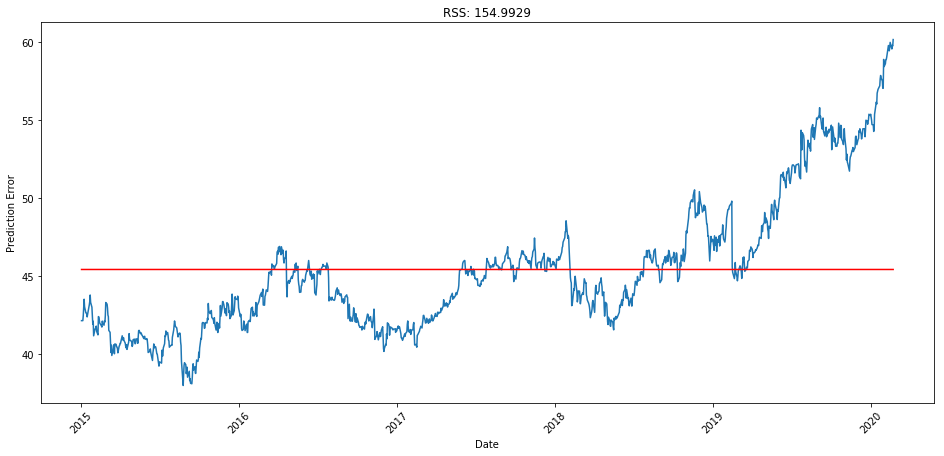

ARIMA Model #1 - Parameters: (p = 0, d = 0, q = 0)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


82.13522814944987


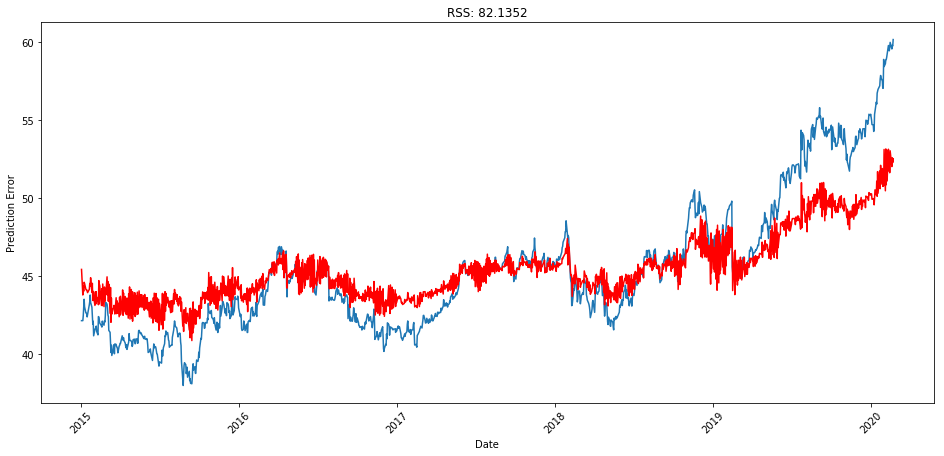

ARIMA Model #2 - Parameters: (p = 0, d = 0, q = 1)
53.181550777194104


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


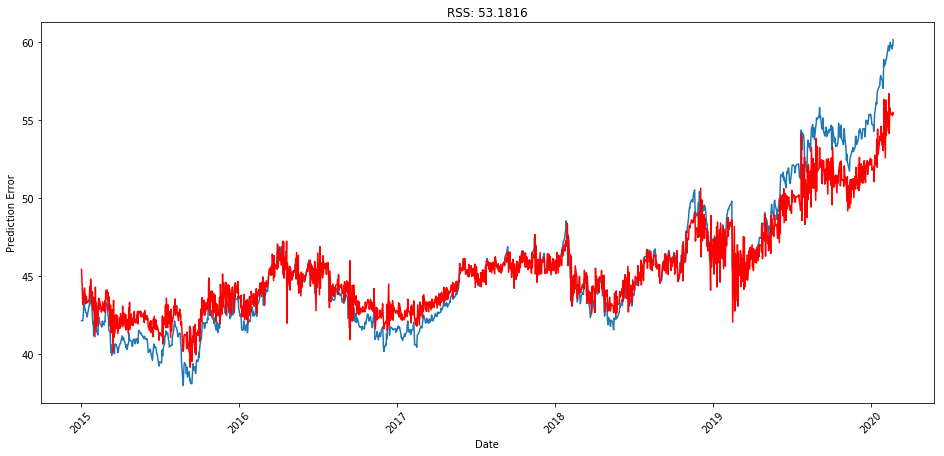

ARIMA Model #3 - Parameters: (p = 0, d = 0, q = 2)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


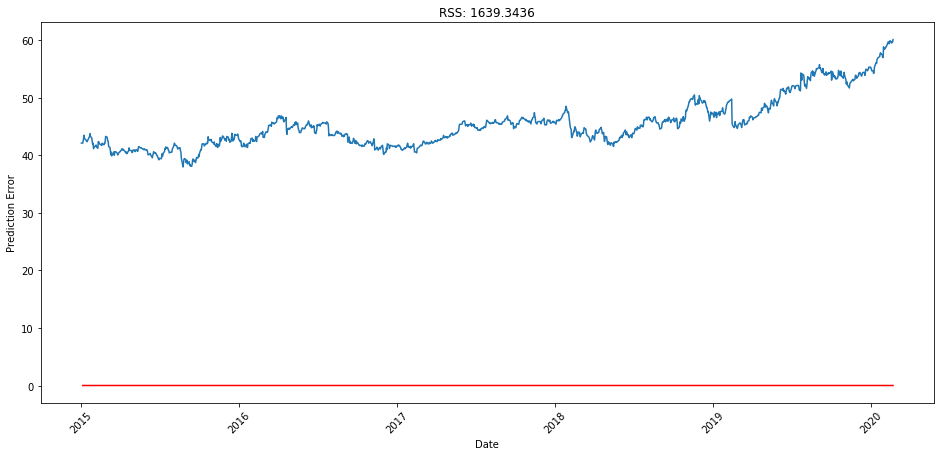

ARIMA Model #4 - Parameters: (p = 0, d = 1, q = 0)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


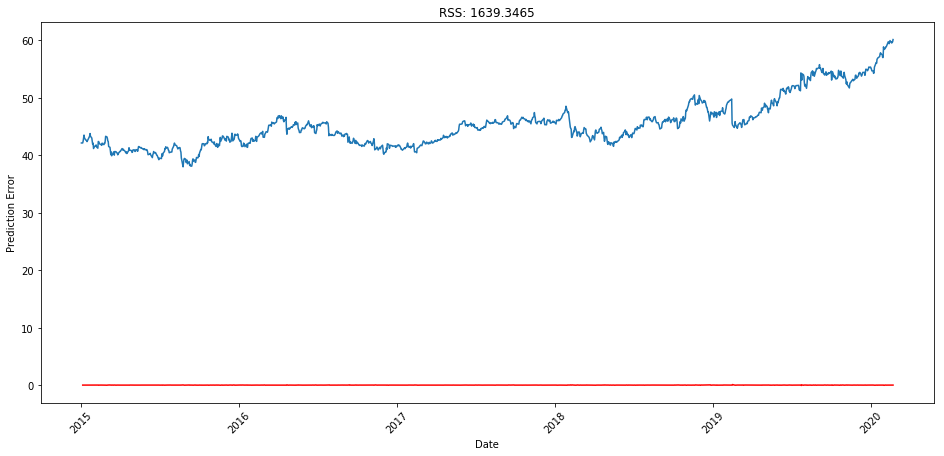

ARIMA Model #5 - Parameters: (p = 0, d = 1, q = 1)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


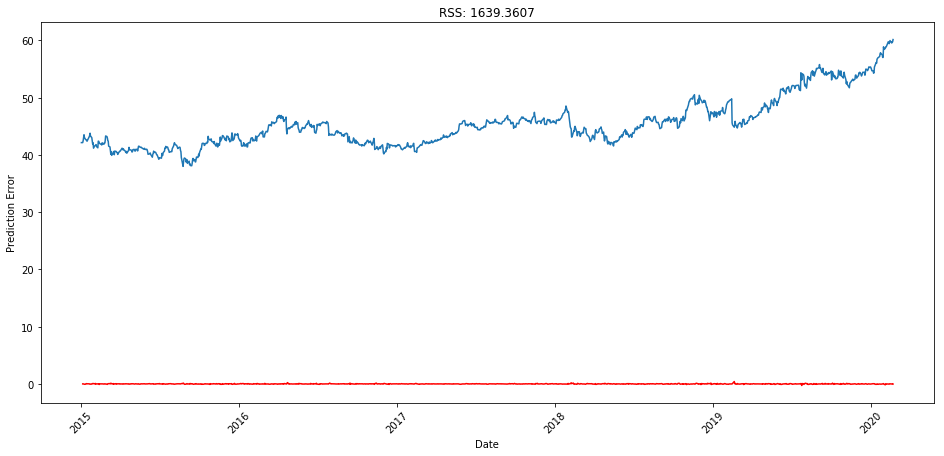

ARIMA Model #6 - Parameters: (p = 0, d = 1, q = 2)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


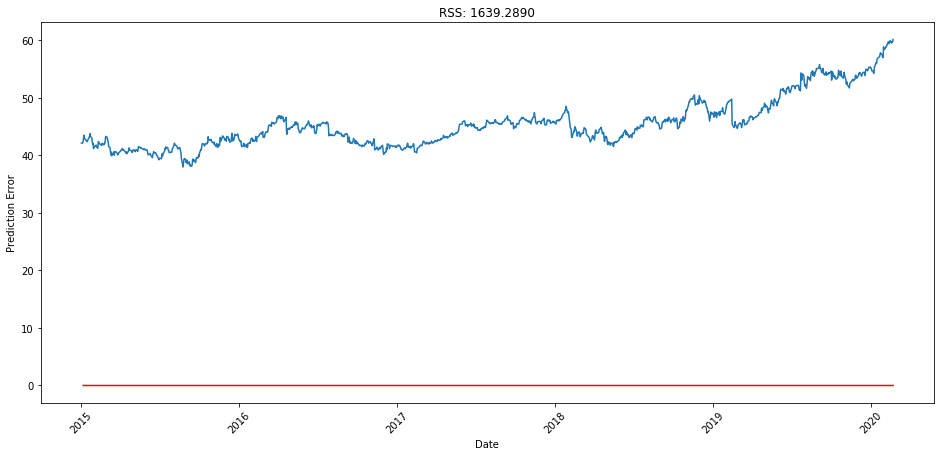

ARIMA Model #7 - Parameters: (p = 0, d = 2, q = 0)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


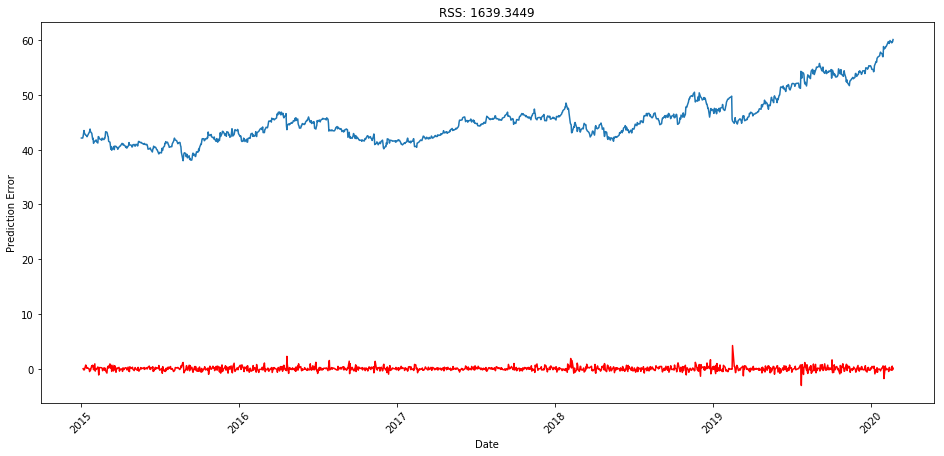

ARIMA Model #8 - Parameters: (p = 0, d = 2, q = 1)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


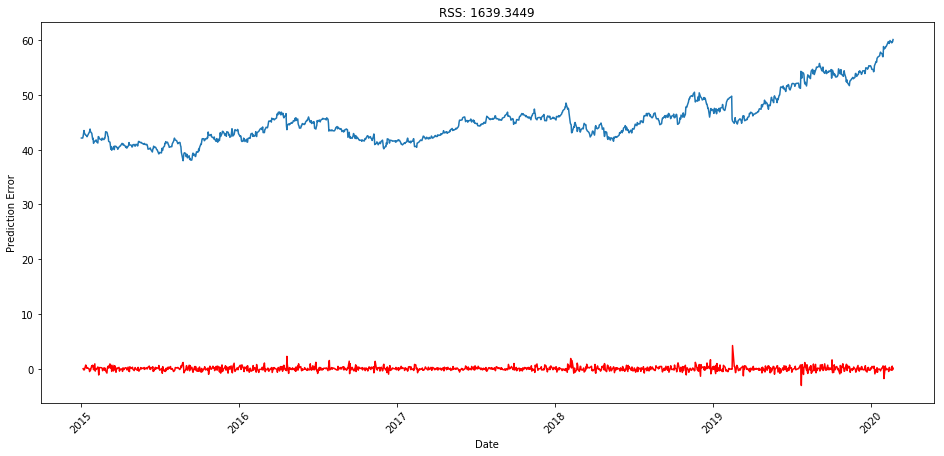

ARIMA Model #9 - Parameters: (p = 0, d = 2, q = 2)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


15.97221305197931


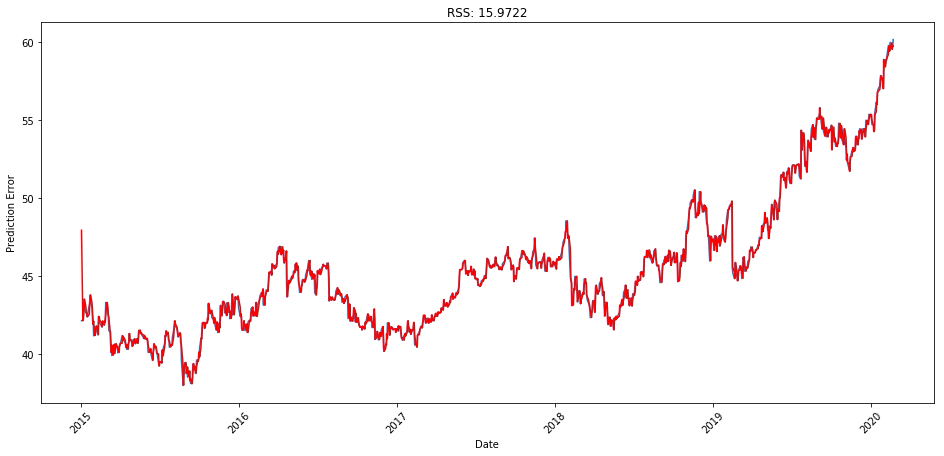

ARIMA Model #10 - Parameters: (p = 1, d = 0, q = 0)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


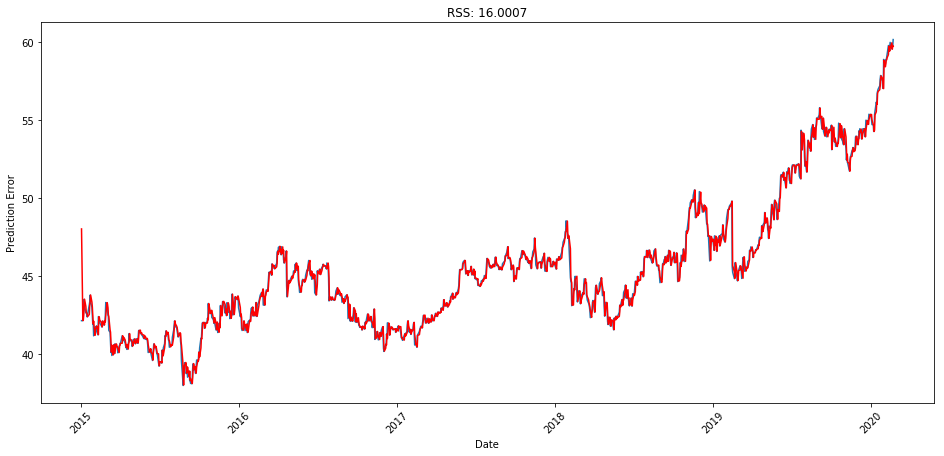

ARIMA Model #11 - Parameters: (p = 1, d = 0, q = 1)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


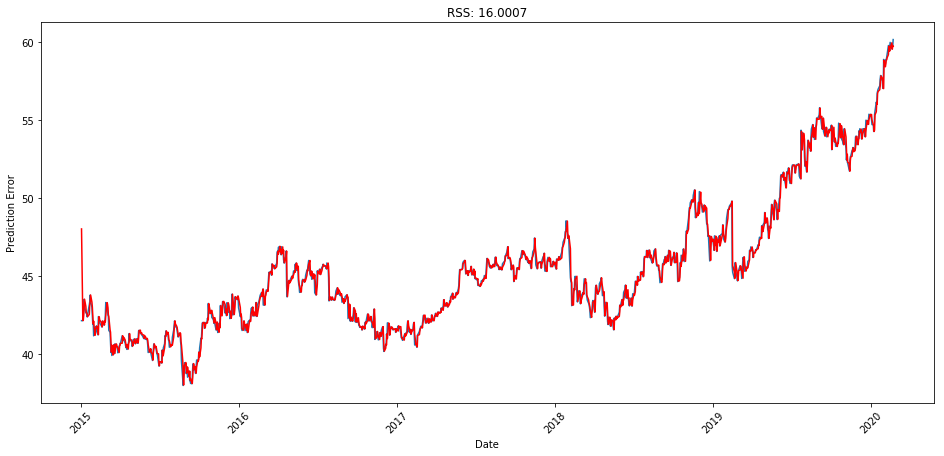

ARIMA Model #12 - Parameters: (p = 1, d = 0, q = 2)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


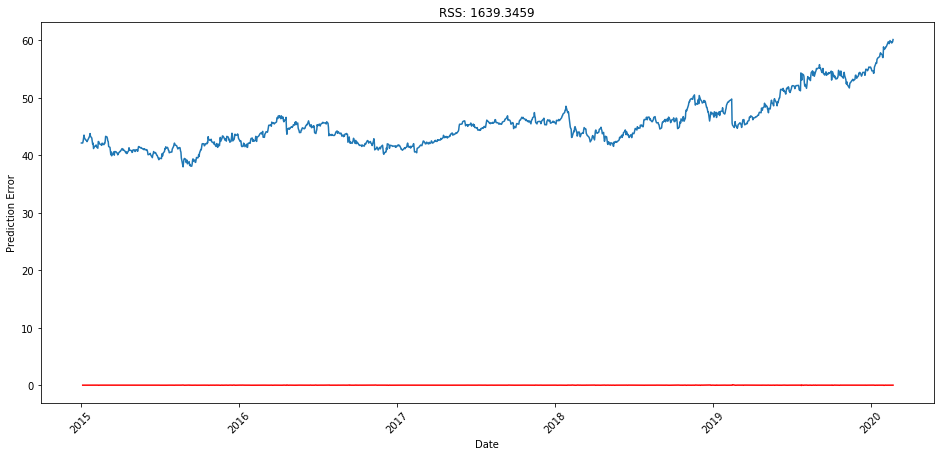

ARIMA Model #13 - Parameters: (p = 1, d = 1, q = 0)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


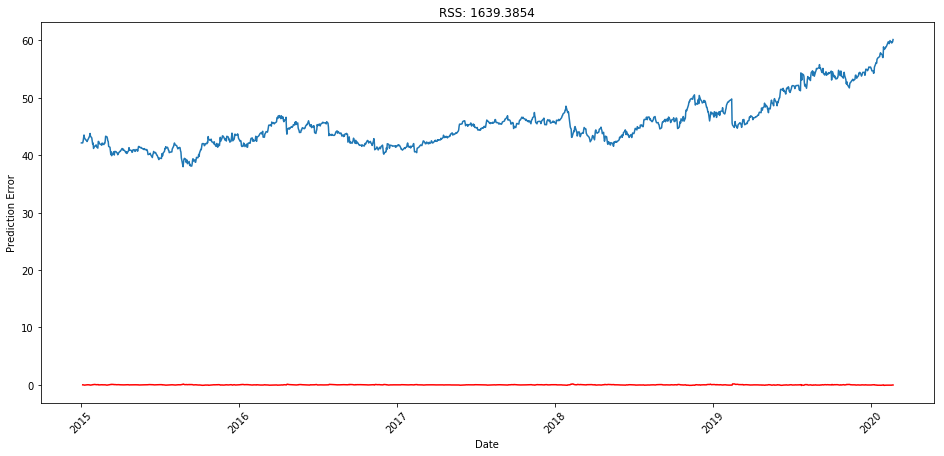

ARIMA Model #14 - Parameters: (p = 1, d = 1, q = 1)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


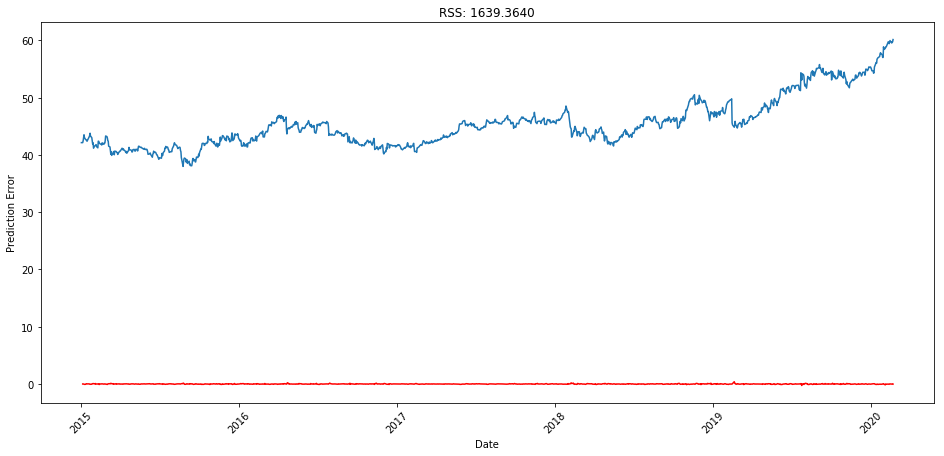

ARIMA Model #15 - Parameters: (p = 1, d = 1, q = 2)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


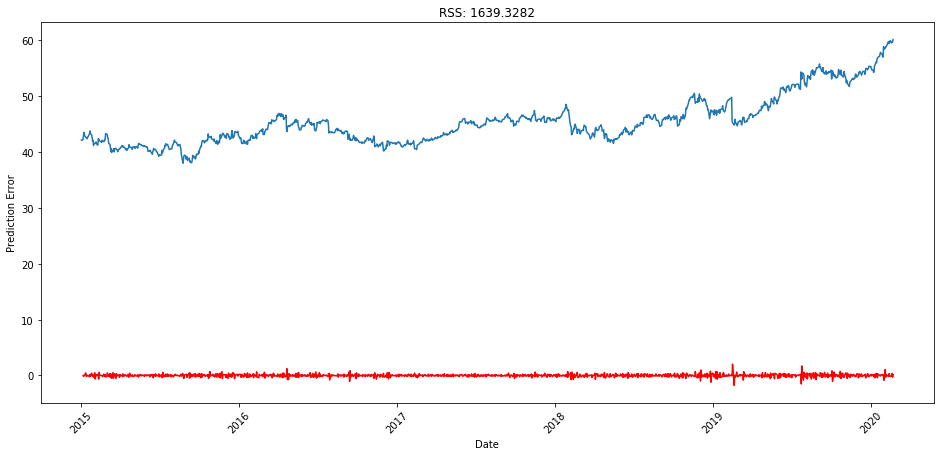

ARIMA Model #16 - Parameters: (p = 1, d = 2, q = 0)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


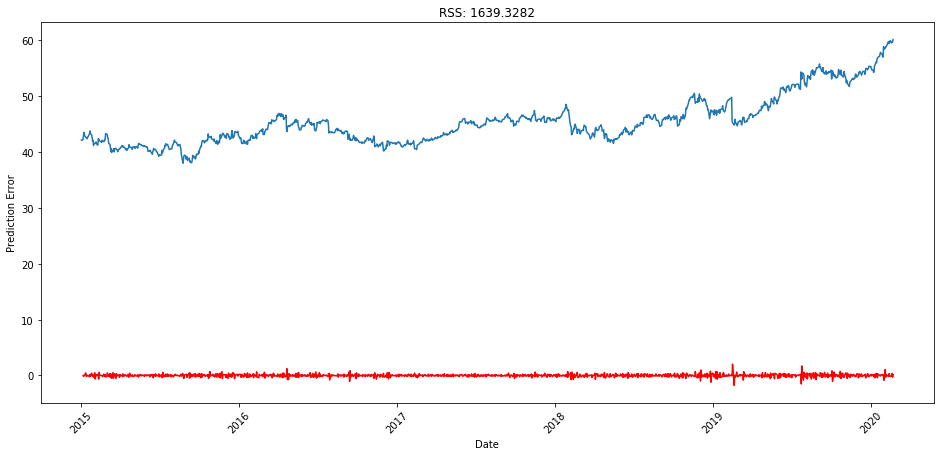

ARIMA Model #17 - Parameters: (p = 1, d = 2, q = 1)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


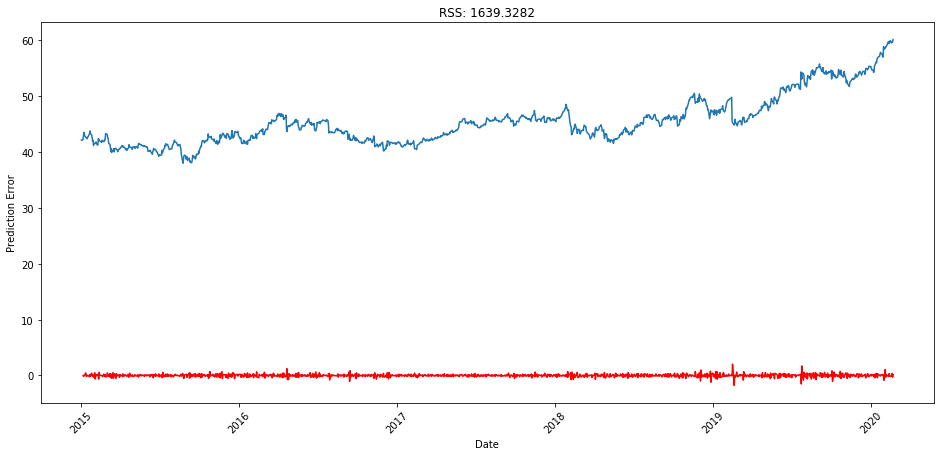

ARIMA Model #18 - Parameters: (p = 1, d = 2, q = 2)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


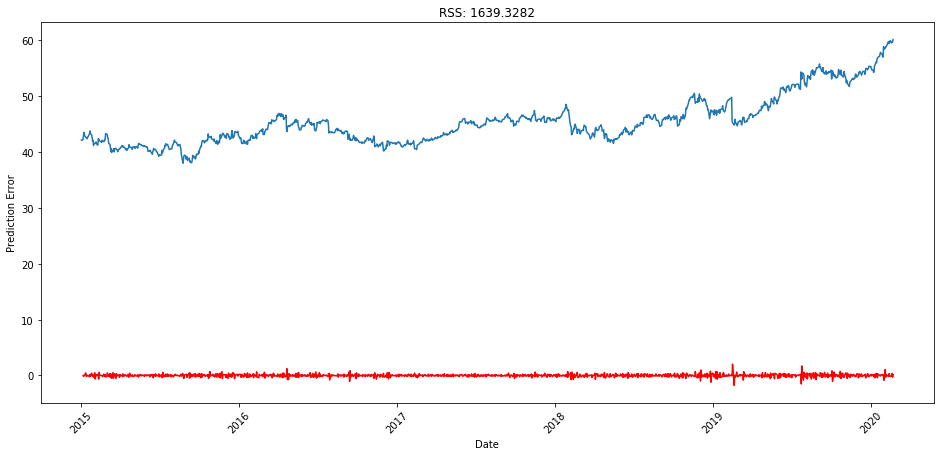

ARIMA Model #19 - Parameters: (p = 2, d = 0, q = 0)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


15.918009606279323


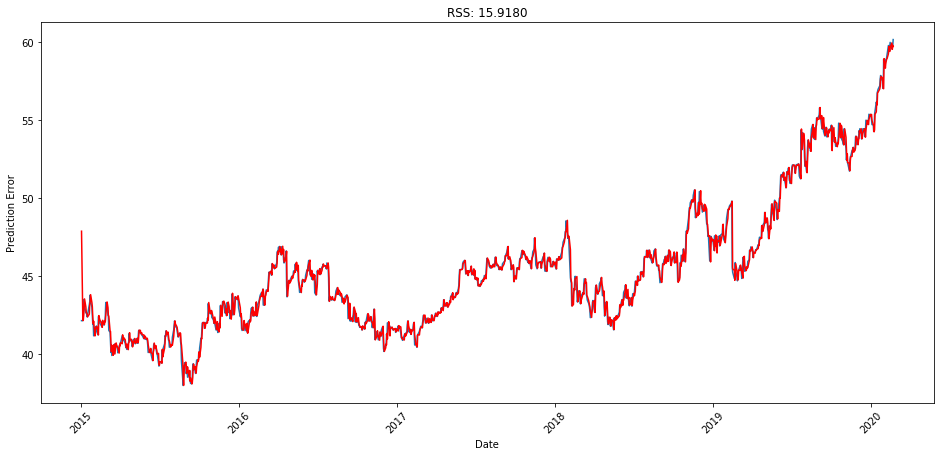

ARIMA Model #20 - Parameters: (p = 2, d = 0, q = 1)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


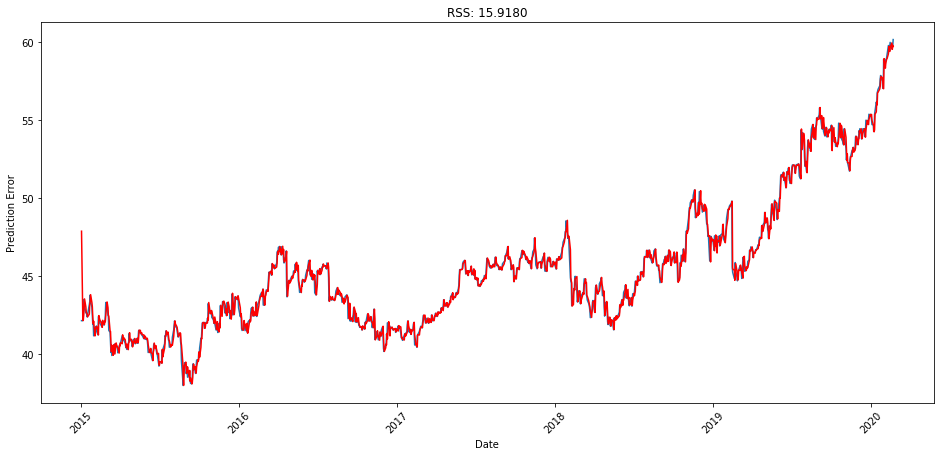

ARIMA Model #21 - Parameters: (p = 2, d = 0, q = 2)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


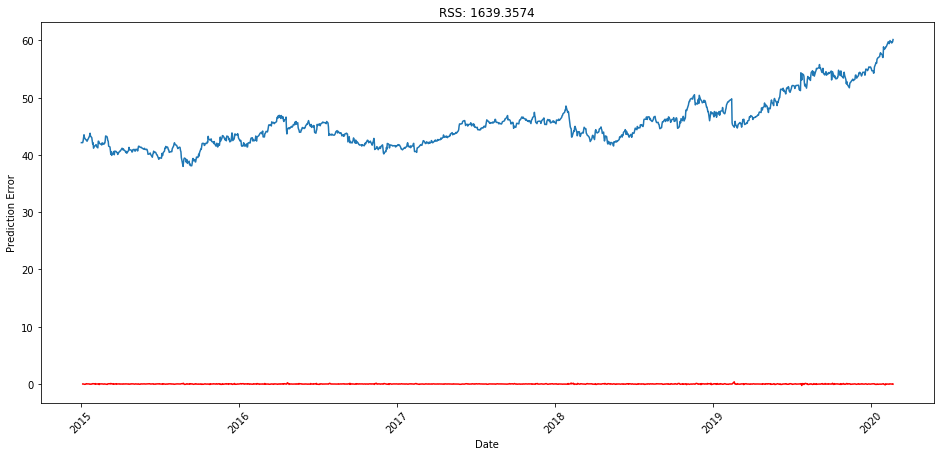

ARIMA Model #22 - Parameters: (p = 2, d = 1, q = 0)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


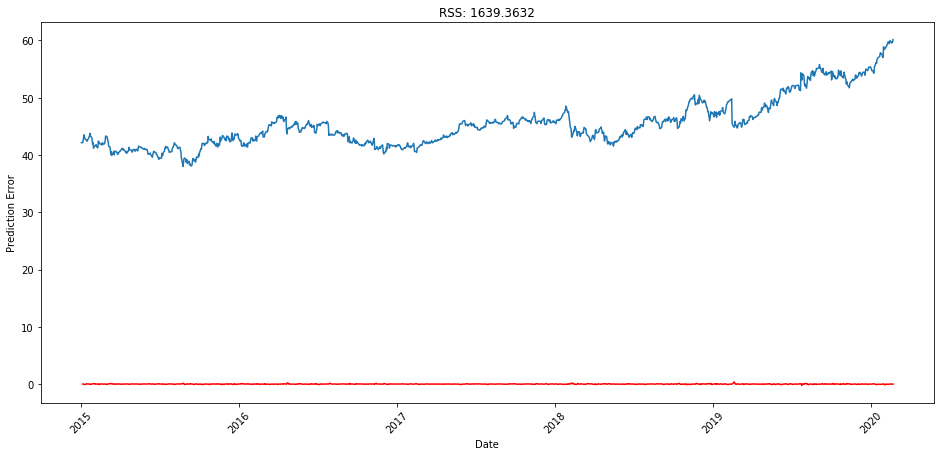

ARIMA Model #23 - Parameters: (p = 2, d = 1, q = 1)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


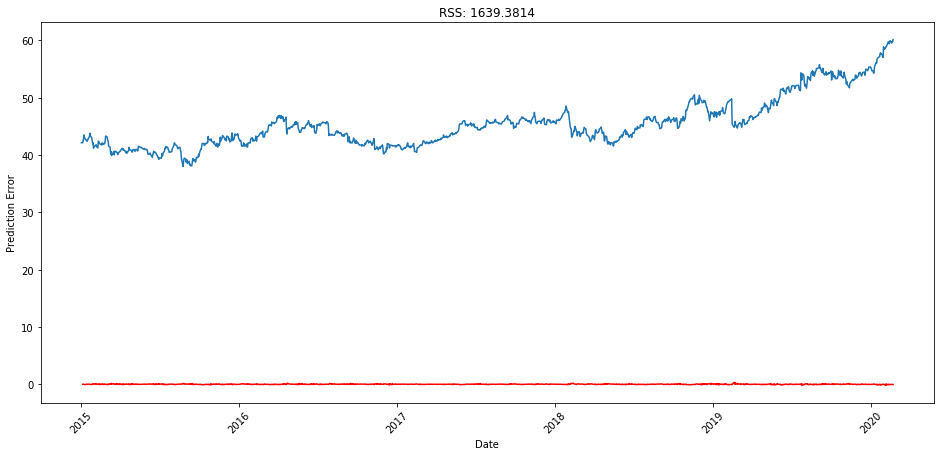

ARIMA Model #24 - Parameters: (p = 2, d = 1, q = 2)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


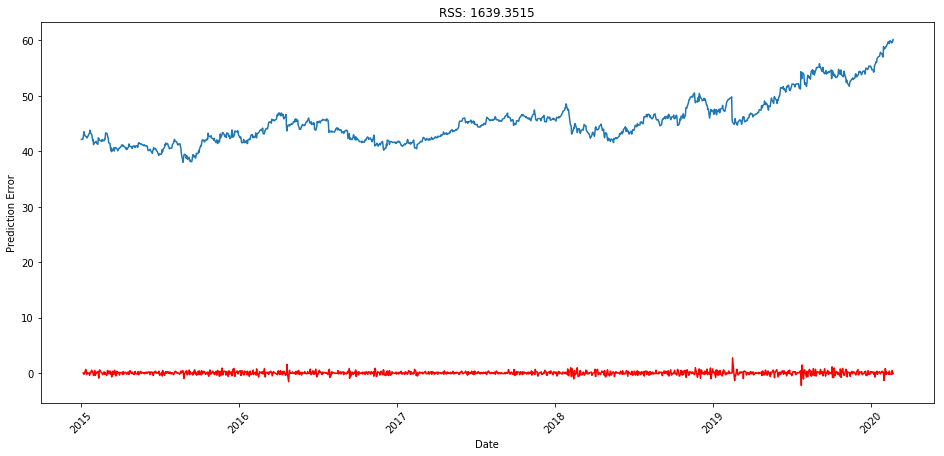

ARIMA Model #25 - Parameters: (p = 2, d = 2, q = 0)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


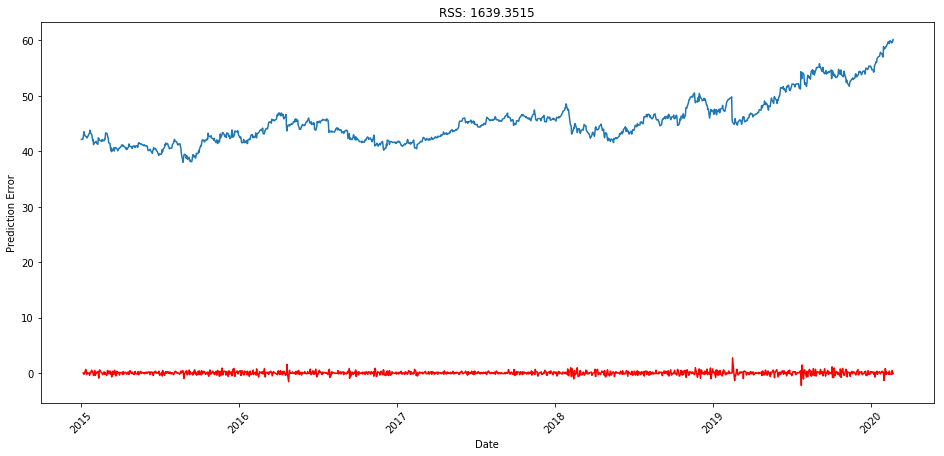

/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA Model #26 - Parameters: (p = 2, d = 2, q = 1)


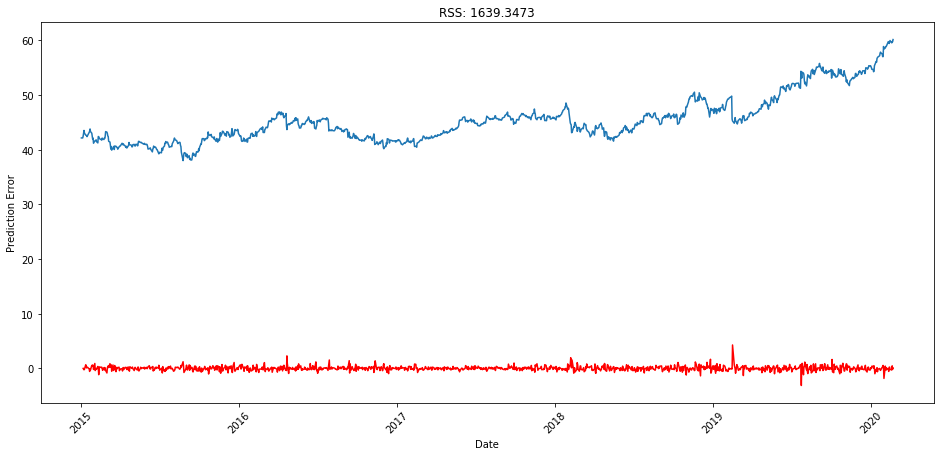

ARIMA Model #27 - Parameters: (p = 2, d = 2, q = 2)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


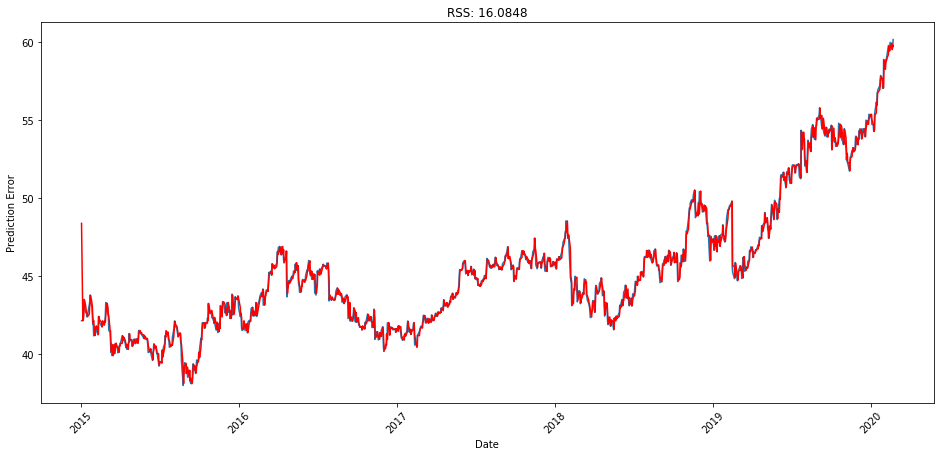

ARIMA Model #28 - Parameters: (p = 3, d = 0, q = 0)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


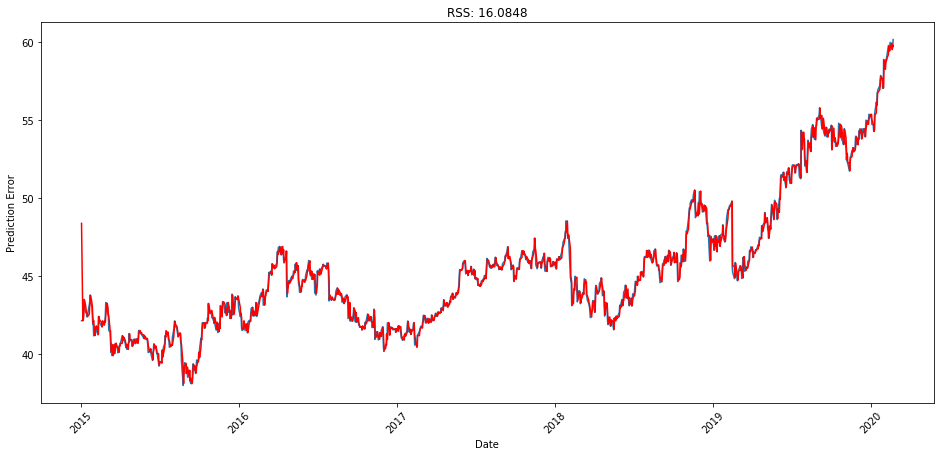

ARIMA Model #29 - Parameters: (p = 3, d = 0, q = 1)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


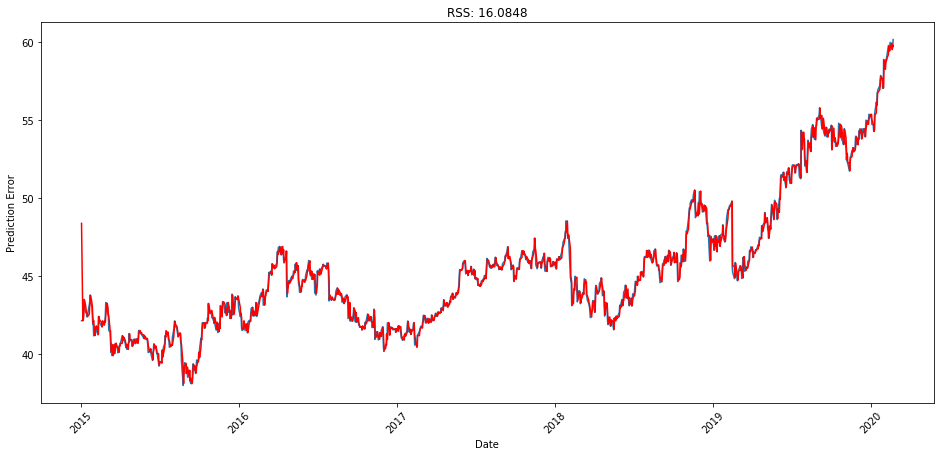

ARIMA Model #30 - Parameters: (p = 3, d = 0, q = 2)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


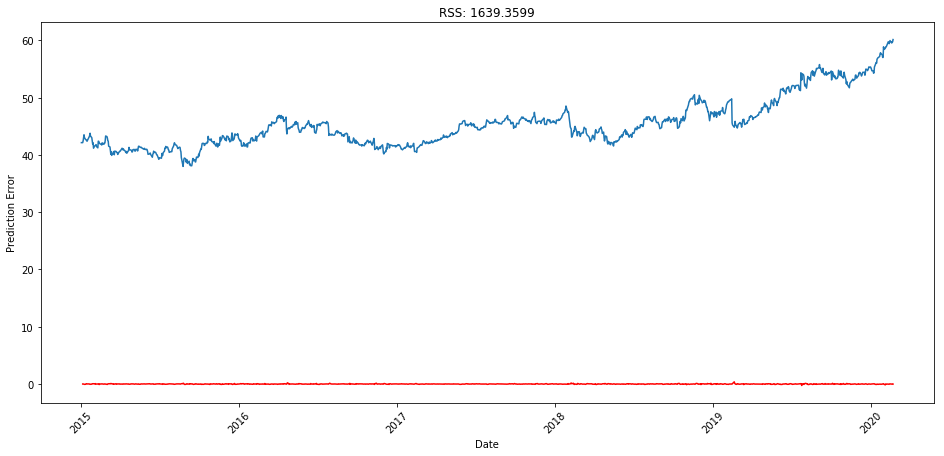

ARIMA Model #31 - Parameters: (p = 3, d = 1, q = 0)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


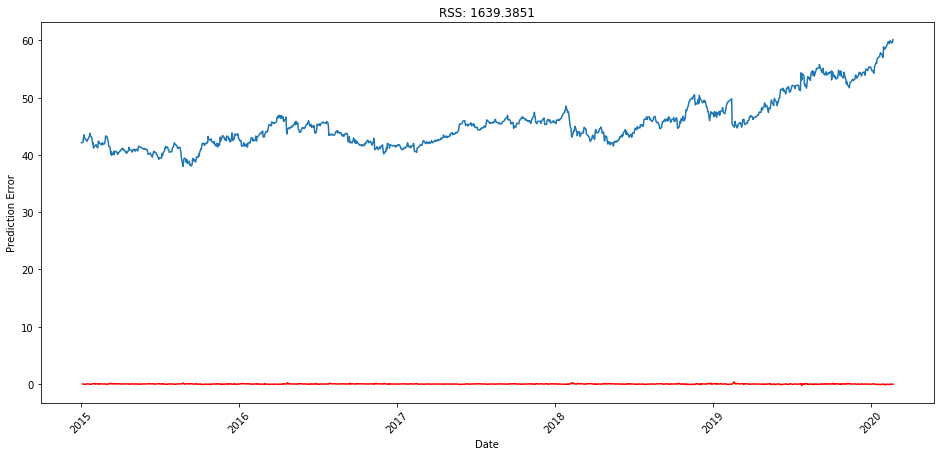

ARIMA Model #32 - Parameters: (p = 3, d = 1, q = 1)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


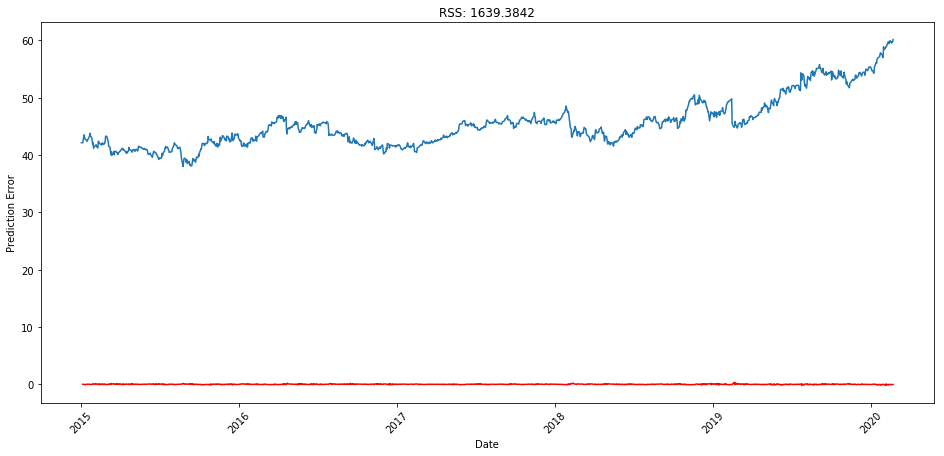

ARIMA Model #33 - Parameters: (p = 3, d = 1, q = 2)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


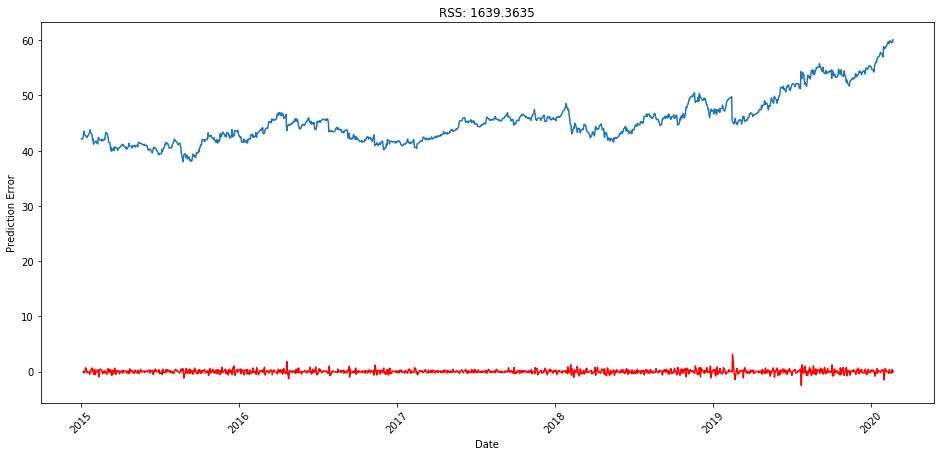

ARIMA Model #34 - Parameters: (p = 3, d = 2, q = 0)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


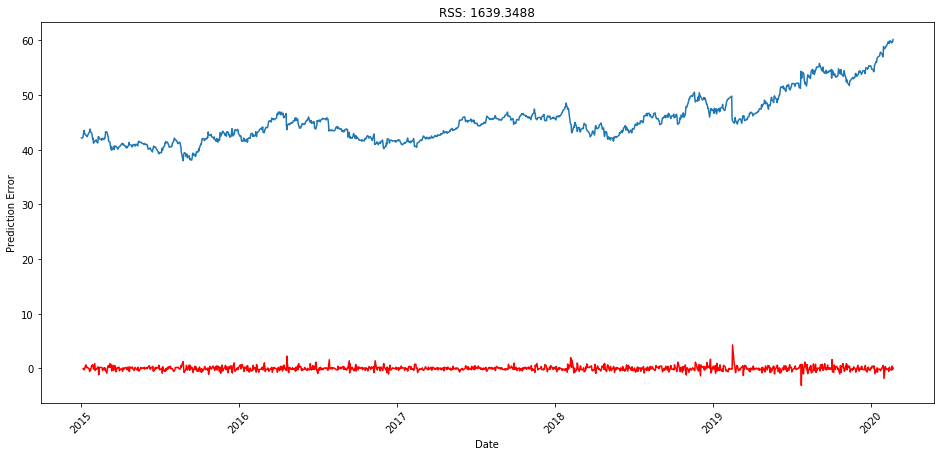

ARIMA Model #35 - Parameters: (p = 3, d = 2, q = 1)


/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/swee/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


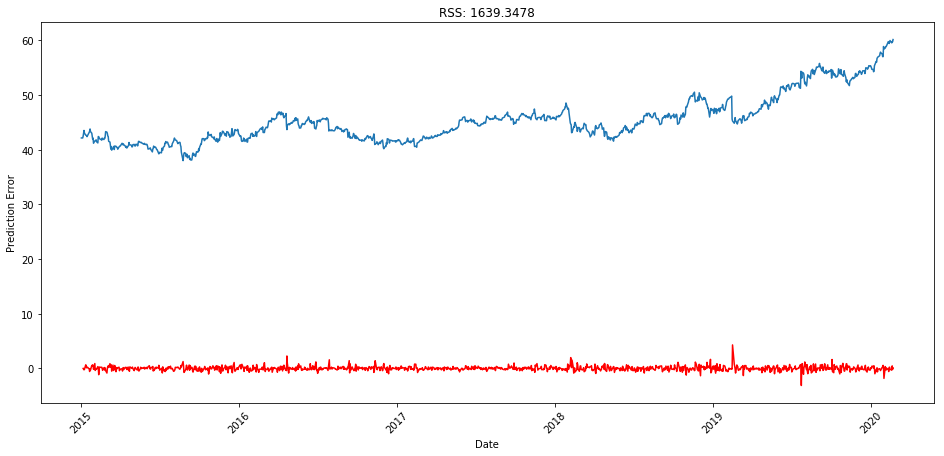

ARIMA Model #36 - Parameters: (p = 3, d = 2, q = 2)


In [15]:
# Perform grid search to determine p, d, and q
loss_best = 1E16
best_ints = [-1,-1,-1]
counter = 1
all_models = {}
for p in range(4):
    for d in range(3):
        for q in range(3):
            model = ARIMA(price.dropna(), order=(p, d, q))              
#             model = ARIMA(diff, order=(p, d, q))    #should we fit the difference instead?         
            try:
                results_ARIMA = model.fit(disp=-1)
                all_models[counter] = results_ARIMA
            except ValueError:
                pass
            except:
                pass
            plt.plot(price)
            plt.plot(results_ARIMA.fittedvalues, color='red')            
            x=pd.DataFrame(results_ARIMA.fittedvalues)
            x=x.join(price)
            x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
            loss=np.sqrt(x['out'].sum())
            plt.xlabel("Date")
            plt.ylabel("Prediction Error")
            plt.title('RSS: %.4f'% loss)  
            #plt.title(f"AIC: {results_ARIMA.aic:.2f}")
            plt.xticks(rotation=45)
            if loss < loss_best:
                print(loss)
                loss_best = loss
                best_ints=[p,d,q]
            plt.show()
            #print(p,d,q)
            print(f"ARIMA Model #{counter} - Parameters: (p = {p}, d = {d}, q = {q})")
            counter += 1

In [16]:
print(loss_best)
print(best_ints)

15.918009606279323
[2, 0, 1]


The grid search suggests ARIMA (2,0,1) as the best model, the residual sum of squares (RSS) is 15.918, which is the lowest among all the models. The predicted values using ARIMA (2,0,1) aligns pretty well with the original stock price data. 

The best model that determines by the gridsearch does not violate rule 8 for `p` and `q`, which states that both of them cannot be greater than 1, so no adjustment is needed. The output below shows the summary statistics of the ARIMA (2,0,1) model. 


In [17]:
best_model = all_models[20]
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1293
Model:                     ARMA(2, 1)   Log Likelihood                -694.636
Method:                       css-mle   S.D. of innovations              0.413
Date:                Sun, 01 Mar 2020   AIC                           1399.271
Time:                        21:42:44   BIC                           1425.095
Sample:                             0   HQIC                          1408.963
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          47.8641      4.475     10.695      0.000      39.093      56.636
ar.L1.Close     0.1284      0.068      1.885      0.060      -0.005       0.262
ar.L2.Close     0.8677      0.068     12.753      0.000       0.734       1.001
ma.L1.Close     0.9031      0.059     15.386      0.000       0.788       1.018
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0021           +0.0000j            1.0021            0.0000
AR.2           -1.1501           +0.0000j            1.1501            0.5000
MA.1           -1.1073           +0.0000j            1.1073            0.5000
-----------------------------------------------------------------------------
"""

#### Forecast for Coca-Cola Stock Price

Although the stock price data are difficult to predict, out of curiosity, we use the resulting best model from the grid search to forecast Coca-Cola stock price for the next 30 days. 

In [18]:
def forecast(model, days=30):
    # invert differenced value
    def inverse_difference(history, yhat, interval=1):
        return yhat 
        return yhat + history[-interval]

    new_index = pd.date_range(price.index[-1] + datetime.timedelta(days=1),
                              price.index[-1] + datetime.timedelta(days=days))
    X = price.values
    forecast = model.forecast(steps=days)[0]
    history = [x for x in X]
    day = 1
    for yhat in forecast:
        inverted = inverse_difference(history, yhat)
        history.append(inverted)
        day += 1
    return pd.Series(data=history[-30:], index=new_index)

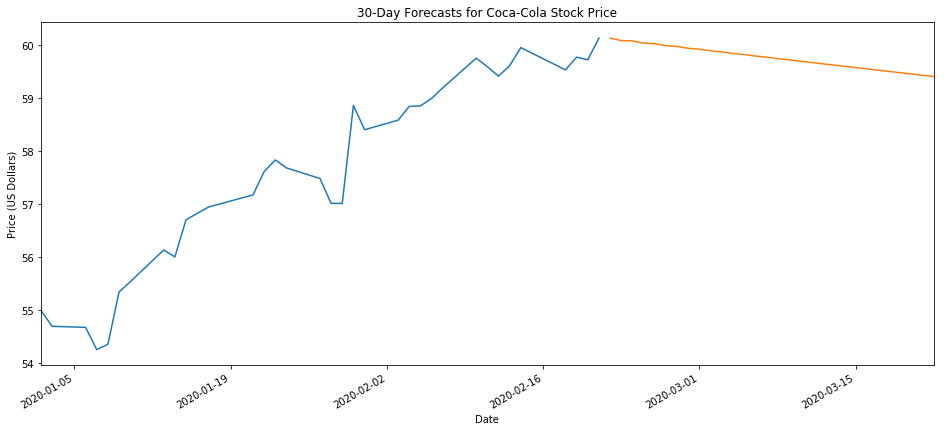

In [19]:
price[price.index > '01-01-2020'].plot()
ax = forecast(best_model).plot()
_ = ax.set(title=f'30-Day Forecasts for Coca-Cola Stock Price', ylabel='Price (US Dollars)', xlabel='Date')

   Figure 11. A Time Series Window that shows the Coca-Cola Stock Price Starting January 1, 2020 along with the 30-Day forecasts (in Orange).

The forecasts in Figure 11 show a downward trend over the next 30 days. As we mentioned earlier, the stock price in general fluctuates and no one could be able to predict what the stock price would be the next day. Therefore, we would not bet on the forecasts, however, it is good to see what type of forecasts an ARIMA (2,0,1) would produce given the data. 

### Conclusion

From this analysis, we learned that we can subtract rolling mean or apply differencing to make a time series stationary by removing the trend in the data. We also learned that we can use grid search to find the p, d, q parameters of an ARIMA model, in order to get the best optimal model that describes the data well. 

By differencing the data and manually fitting the Coca-Cola stock price, we obtain the ARIMA (1,1,0) and ARIMA (0,1,1) as the best models. However, the grid search suggests that ARIMA (2,0,1) (also referred to as
ARMA (2,1)) is the best model for fitting the stock data. There is no differencing term (d) in the model. Differencing is a method that is used to remove the series dependence on time. With any types of stock data in general, it is very unpredictable - today's stock price has little to no dependency on yesterday's price, hence it makes sense to not include a differencing term in the model. 


### Sources

[1] http://dividendvaluebuilder.com/coca-cola-ko-stock-analysis/

[2] http://dividendvaluebuilder.com/dividend-kings-list/

[3] https://www.investopedia.com/terms/m/megacap.asp

[4] https://www.fool.com/investing/2017/11/21/the-30-dow-jones-stocks.aspx

[5] https://www.coca-cola.co.uk/faq/how-many-cans-of-coca-cola-are-sold-worldwide-in-a-day

[6] https://s3-us-west-2.amazonaws.com/smu-mds/prod/Quantifying+the+World/2019-05-05+DS+7333+Quantifying+the+World/Supplemental/Week+8/MSDS7333_Wk8_Synch.pdf